<a href="https://colab.research.google.com/github/mattemugno/seai_project/blob/master/OLD_models/Training_Keras_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!!pip install --upgrade git+https://github.com/keras-team/keras-cv

['Collecting git+https://github.com/keras-team/keras-cv',
 '  Cloning https://github.com/keras-team/keras-cv to /tmp/pip-req-build-v_6vo82n',
 '  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv /tmp/pip-req-build-v_6vo82n',
 '  Resolved https://github.com/keras-team/keras-cv to commit a9fea08d8c362006658ec91b7f799158b8040936',
 '  Installing build dependencies ... \x1b[?25l\x1b[?25hdone',
 '  Getting requirements to build wheel ... \x1b[?25l\x1b[?25hdone',
 '  Preparing metadata (pyproject.toml) ... \x1b[?25l\x1b[?25hdone',
 'Requirement already satisfied: packaging in /usr/local/lib/python3.10/dist-packages (from keras-cv==0.6.2) (23.1)',
 'Requirement already satisfied: absl-py in /usr/local/lib/python3.10/dist-packages (from keras-cv==0.6.2) (1.4.0)',
 'Requirement already satisfied: regex in /usr/local/lib/python3.10/dist-packages (from keras-cv==0.6.2) (2023.6.3)',
 'Requirement already satisfied: tensorflow-datasets in /usr/local/lib/py

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
from keras_cv import visualization
import numpy as np

In [ ]:
BATCH_SIZE = 2
NUM_CLASSES = 43
EPOCHS = 30

In [ ]:
class_ids = {
    'speed_limit_20': 1,
    'speed_limit_30': 2,
    'speed_limit_50': 3,
    'speed_limit_60': 4,
    'speed_limit_70': 5,
    'speed_limit_80': 6,
    'restriction_ends_80': 7,
    'speed_limit_100': 8,
    'speed_limit_120': 9,
    'no_overtaking': 10,
    'no_overtaking_trucks': 11,
    'priority_at_next_intersection': 12,
    'priority_road': 13,
    'give_way': 14,
    'stop': 15,
    'no_traffic_both_ways': 16,
    'no_trucks': 17,
    'no_entry': 18,
    'danger': 19,
    'bend_left': 20,
    'bend_right': 21,
    'bend': 22,
    'uneven_road': 23,
    'slippery_road': 24,
    'road_narrows': 25,
    'construction': 26,
    'traffic_signal': 27,
    'pedestrian_crossing': 28,
    'school_crossing': 29,
    'cycles_crossing': 30,
    'snow': 31,
    'animals': 32,
    'restriction_ends': 33,
    'go_right': 34,
    'go_left': 35,
    'go_straight': 36,
    'go_right_or_straight': 37,
    'go_left_or_straight': 38,
    'keep_right': 39,
    'keep_left': 40,
    'roundabout': 41,
    'restriction_ends_overtaking': 42,
    'restriction_ends_overtaking_trucks': 43
}

keys_array = list(class_ids.keys())
class_mapping = dict(zip(range(1, len(class_ids) + 1), class_ids))

#Load dataset

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=8,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

def parse_tfrecord(example_proto):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64)
    }
    # Estrarre i dati dal file TFRecord
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_image(example['image/encoded'])
    image.set_shape((None, None, 3))
    xmin = example['image/object/bbox/xmin'].values
    ymin = example['image/object/bbox/ymin'].values
    xmax = example['image/object/bbox/xmax'].values
    ymax = example['image/object/bbox/ymax'].values
    class_id = example['image/object/class/label'].values
    bounding_box = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
    bbox = {
        "classes": tf.cast(class_id, dtype=tf.float32),
        "boxes": tf.cast(bounding_box, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bbox}

train_ds = tf.data.TFRecordDataset('/content/drive/MyDrive/pretrained_gtsdb/tf_saved_model/gtsdb_train.record')
train_ds = train_ds.map(parse_tfrecord)

eval_ds = tf.data.TFRecordDataset('/content/drive/MyDrive/pretrained_gtsdb/tf_saved_model/gtsdb_val.record')
eval_ds = eval_ds.map(parse_tfrecord)

In [ ]:
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

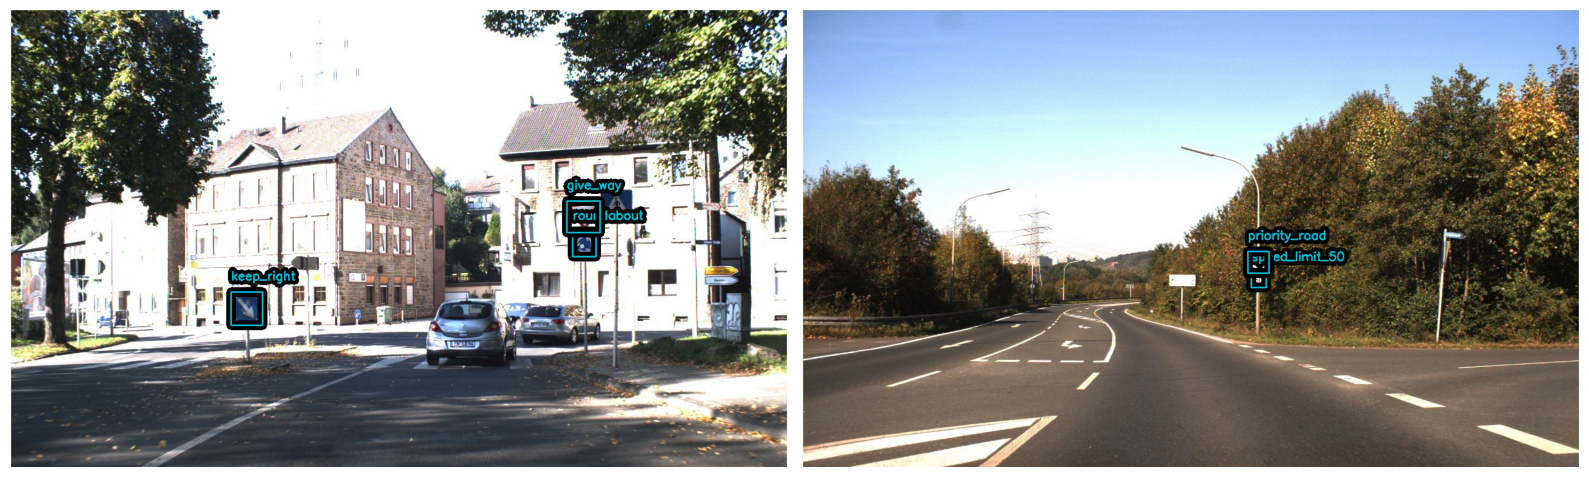

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=1, cols=2
)

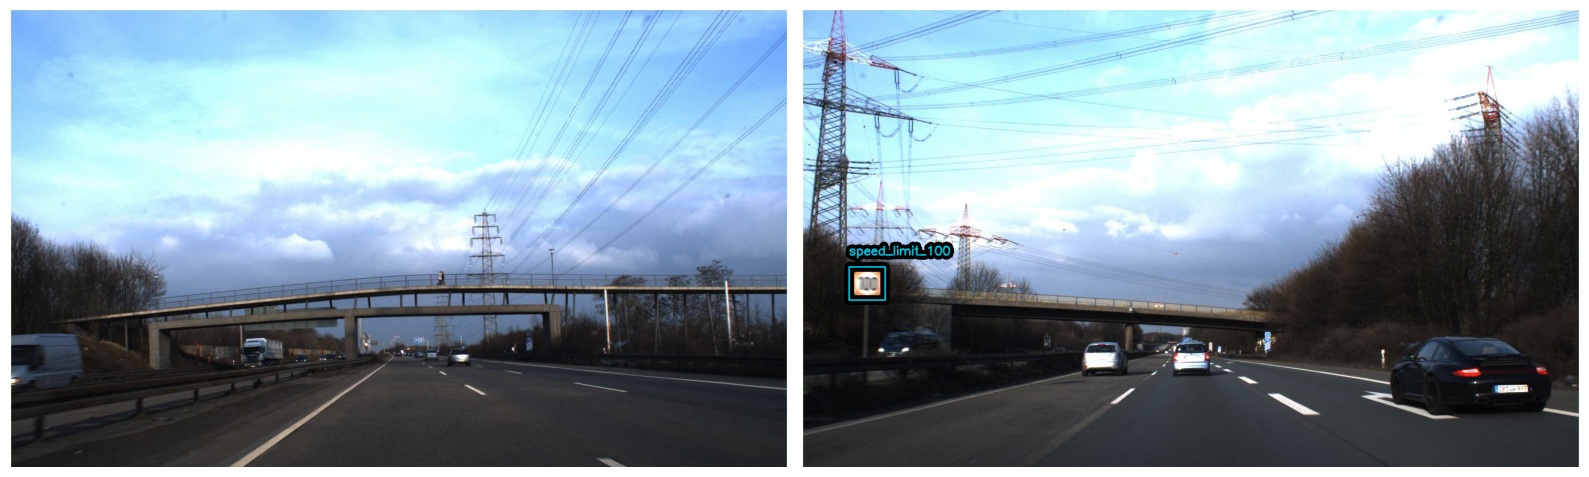

In [ ]:
visualize_dataset(
    eval_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=1, cols=2
)

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="rel_xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="rel_xyxy"
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="rel_xyxy", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
from keras_cv import bounding_box

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

#Train

In [ ]:
base_lr = 0.005
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [ ]:
import time

callbacks_list = [
  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=5,),
  keras.callbacks.ModelCheckpoint(
    filepath = "/content/drive/Shareddrives/seai_project/models/keras_cv" + "/model--epoch-{epoch:02d}--" + str(int(time.time())),
    monitor="val_loss",
    verbose=1,
    save_weights_only=True)]

In [ ]:
def create_model():
  model = keras_cv.models.RetinaNet.from_preset(
      "resnet50_imagenet",
      num_classes=NUM_CLASSES,
      bounding_box_format="rel_xyxy",
  )
  return model

model = create_model()

In [ ]:
model.fit(
    train_ds,
    validation_data=eval_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/30


ValueError: ignored

#Inference *Float32*

In [ ]:
model = create_model()
model.load_weights("/content/drive/Shareddrives/seai_project/models/keras_cv")

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=7,
        rows=3,
        cols=3,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="rel_xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.1,
)

1/1 [==============================] - 1s 786ms/step


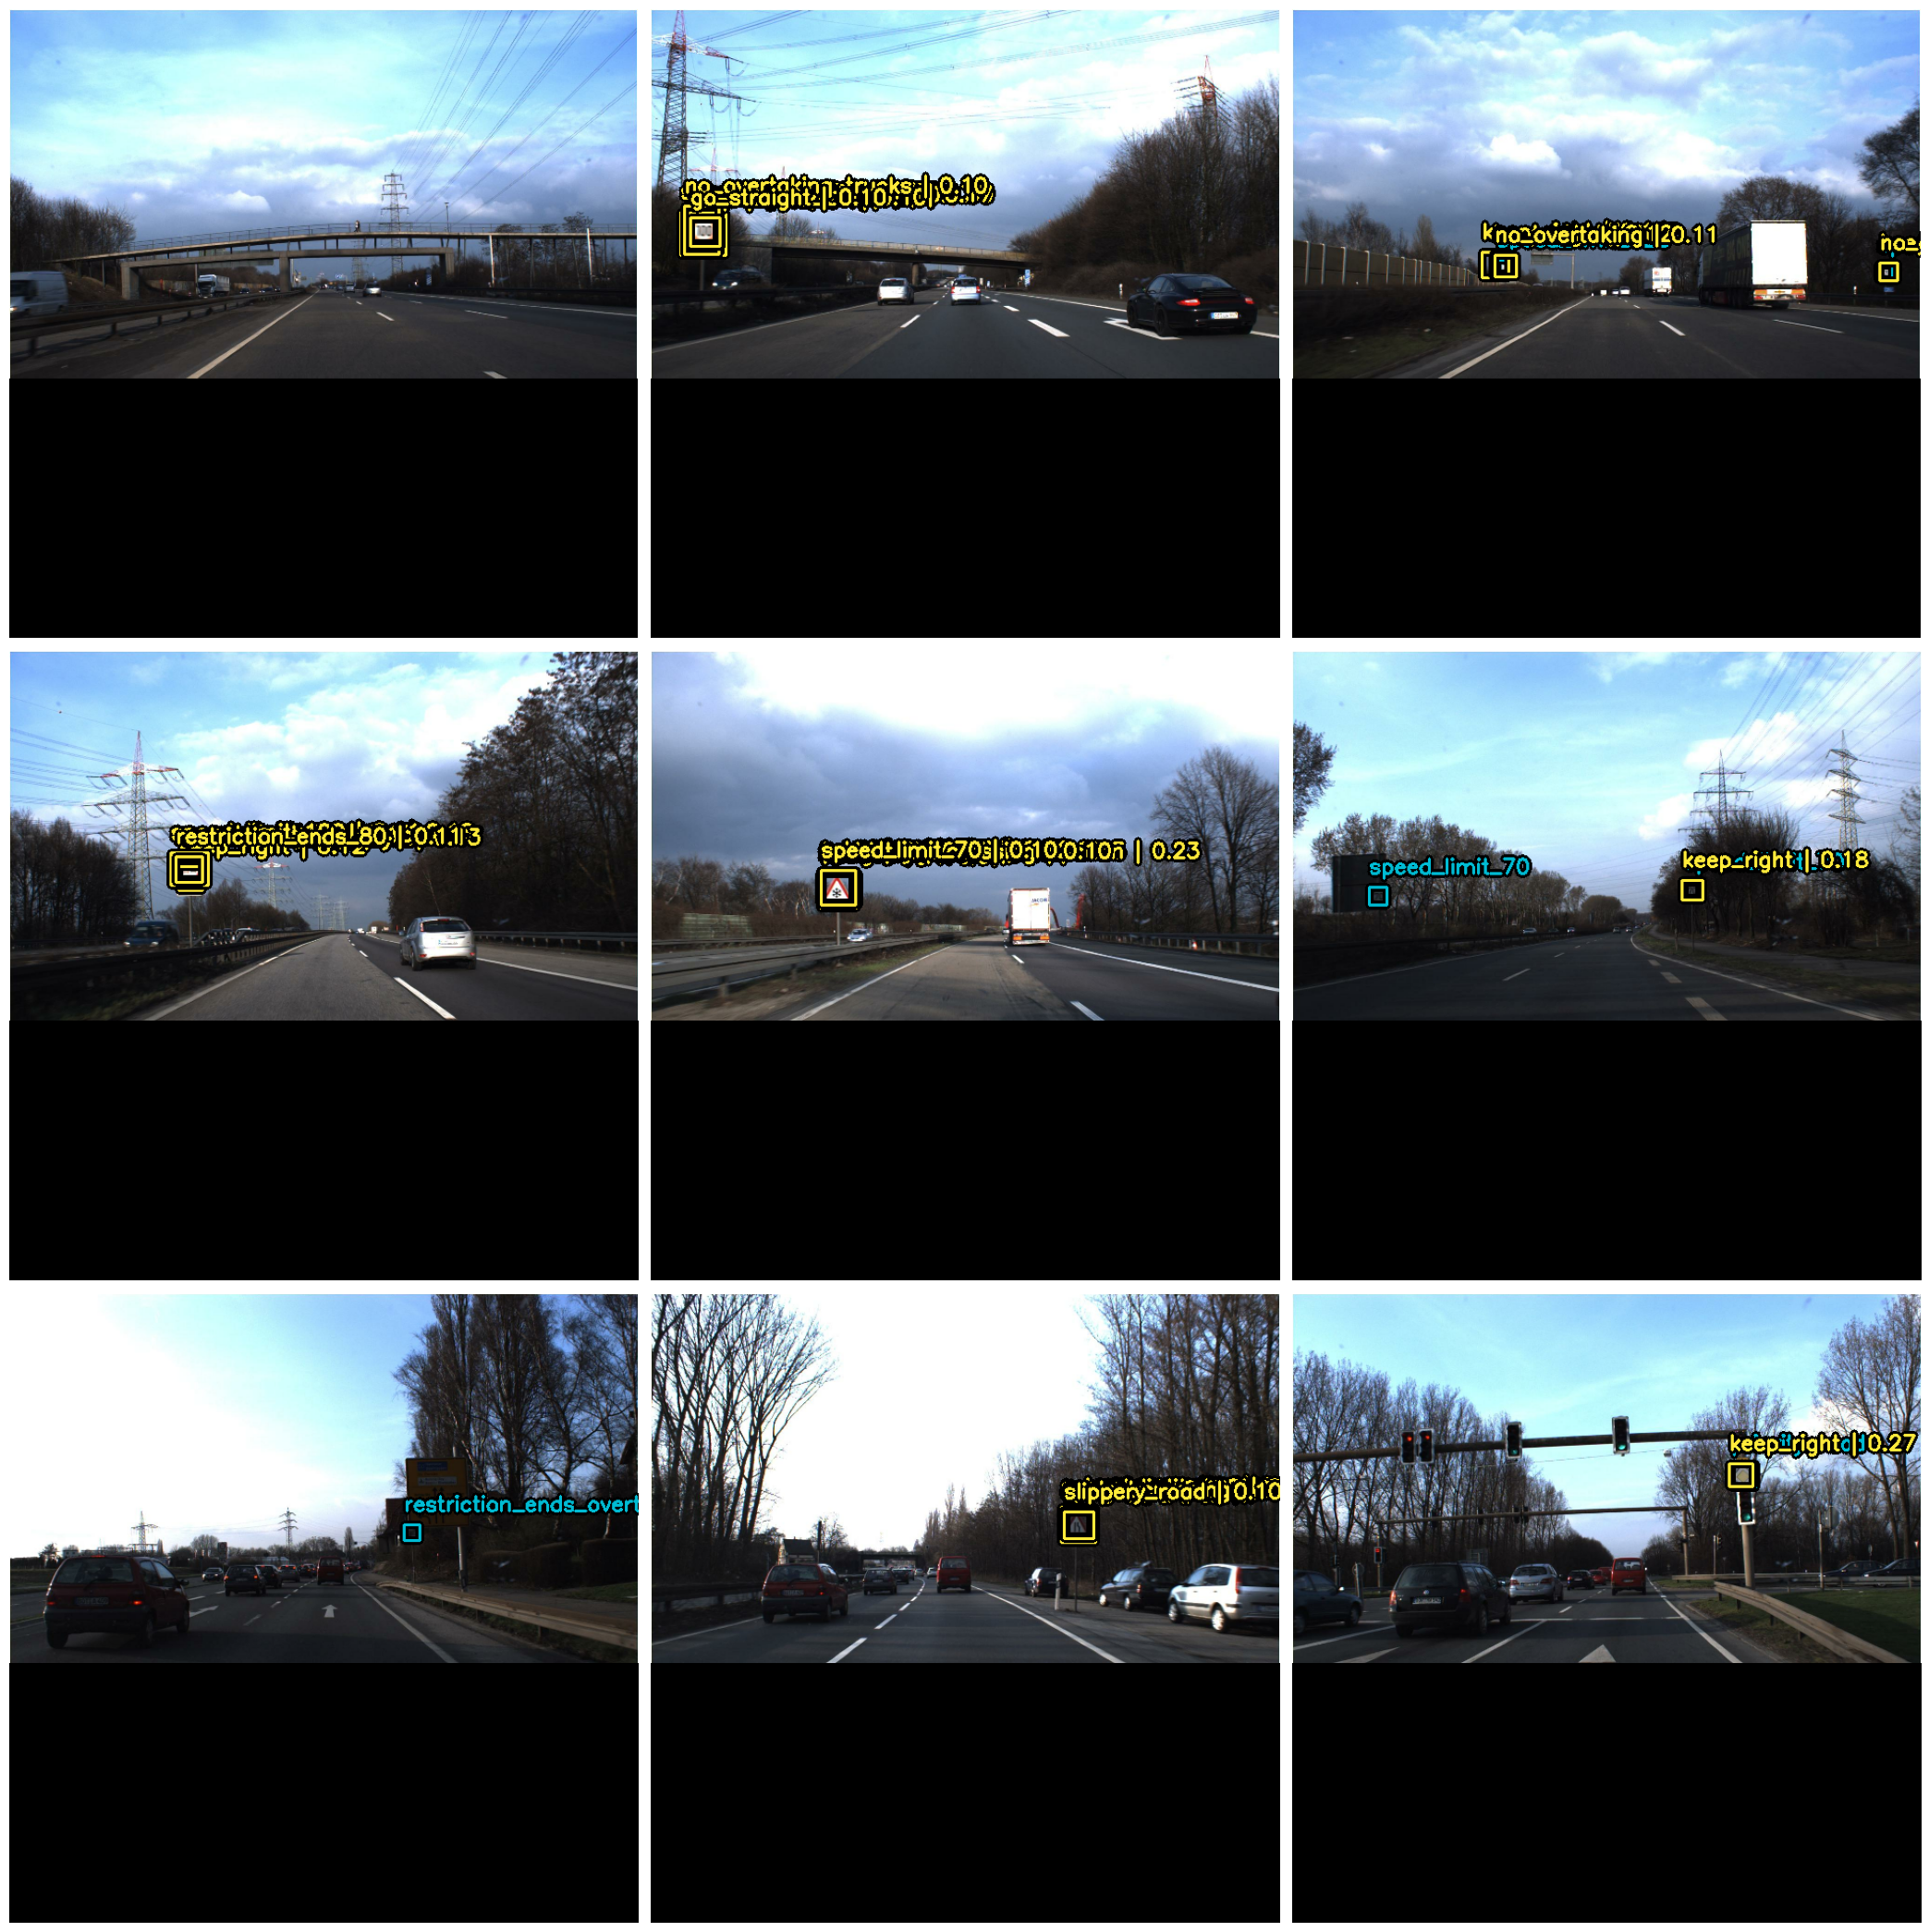

In [ ]:
visualize_detections(model, dataset=visualization_ds, bounding_box_format="rel_xyxy")

In [ ]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def calculate_iou(model, dataset, bounding_box_format):
    ious = []
    for images, y_true in dataset:
        y_pred = model.predict(images, verbose=0)
        y_pred = bounding_box.to_ragged(y_pred)
        for true_boxes, pred_boxes in zip(y_true['boxes'], y_pred['boxes']):
            true_boxes = true_boxes[true_boxes[:, 0] > -1]
            if len(pred_boxes > 0):
              for boxT, boxP in zip(true_boxes, pred_boxes):
                iou = bb_intersection_over_union(boxT, boxP)
                ious.append(iou)
    return ious

ious = calculate_iou(model, dataset=eval_ds, bounding_box_format="rel_xyxy")

In [ ]:
mean = tf.math.reduce_mean(ious)
print(f"IOU: {mean.numpy():.4f}")

IOU: 0.7782


In [ ]:
for i, w in enumerate(model.weights):
    split_name = w.name.split('/')
    new_name = split_name[0] + '_' + str(i) + '/' + split_name[1] + '_' + str(i)
    model.weights[i]._handle_name = new_name

In [ ]:
model.save('/content/drive/MyDrive/pretrained_gtsdb/keras_cv.h5')